# Summary

This notebook provides a breath of all the features offered in the project. 

# Imports/Setup

In [1]:
from Data import dataset, generator
from Data import utility as data_utility
from Evaluation import utility as eval_utility
from Model import linear, scipy
from Model import utility as model_utility
from Objectives import losses

/data/users/jupyter-dam724/.local/lib/python3.9/site-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /data/users/jupyter-dam724/.local/lib/python3.9/site-packages/libpyg.so: undefined symbol: _ZN3c1010Dispatcher17runRecordFunctionERN2at14RecordFunctionESt17reference_wrapperIKNS_14FunctionSchemaEENS_11DispatchKeyE
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/data/users/jupyter-dam724/.local/lib/python3.9/site-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /data/users/jupyter-dam724/.local/lib/python3.9/site-packages/torch_cluster/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/data/users/jupyter-dam724/.local/lib/python3.9/site-packages/torch_geometric/typing.py:113: UserWarning: An issue occurred whil

This configuration class is the central control for the training process.

In [2]:
class Config:
    # dataset
    batch_size = 32
    gen_size = 5
    mat_size = 5**2
    seed = 42
    
    # dataloader
    train_len = 1000
    valid_len = 100
    shuffle = True
    
    # device
    device_pref = 'cuda'
    device_ind = 0
    
    # model
    hidden = 256
    sparse_tol = 1e-2
    diagonal_bias = 0.1
    
    # loss
    l1 =  1e-4
    inv = 1e-5
    dev = 1.0
    cond = 1.0
    
    # training
    epoches = 100
    lr = 1e-5
    verbose = False
    file_path = '/data/users/jupyter-dam724/RL/precondition-discovery-contextual-bandit/RUNS/testing.pth'
    
    # model save/load
    file_path = '/data/users/jupyter-dam724/RL/precondition-discovery-contextual-bandit/RUNS/testing.pth'
    
    # train save/load
    log_path = '/data/users/jupyter-dam724/RL/precondition-discovery-contextual-bandit/RUNS/logs.npz'

# Dataset/Dataloader

There are two different provided test cases, one SPD and the other NID.

In [3]:
train_dataset_params = {
    'generator': generator.generate_2d_diffusion_spd,
    'norm_feat': data_utility.normalize_features,
    'epoch_len': Config.train_len,
    'batch_size': Config.batch_size,
    'size': Config.gen_size
}

valid_dataset_params = {
    'generator': generator.generate_2d_diffusion_spd,
    'norm_feat': data_utility.normalize_features,
    'epoch_len': Config.valid_len,
    'batch_size': Config.batch_size,
    'size': Config.gen_size
}

In [4]:
train_dataset = dataset.SystemDataset(**train_dataset_params)
valid_dataset = dataset.SystemDataset(**valid_dataset_params)

In [5]:
train_dataloader_params = {
    'dataset': train_dataset,
    'batch_size': Config.batch_size,
    'shuffle': Config.shuffle
}

valid_dataloader_params = {
    'dataset': valid_dataset,
    'batch_size': Config.batch_size,
    'shuffle': Config.shuffle
}

In [6]:
train_dataloader = dataset.get_dataloader(**train_dataloader_params)
valid_dataloader = dataset.get_dataloader(**valid_dataloader_params)

In [7]:
A, b = next(iter(train_dataloader))

Determinent: 887868928.0
Matrix is non-singular.
Condition: 7390.01220703125


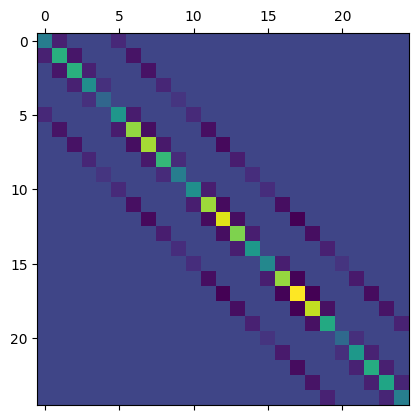

In [8]:
ind = 2
data_utility.check_singularity(A, ind)
data_utility.check_conditioning(A, ind)
data_utility.view_matrix(A, ind)

# Device

Gather the device.

In [9]:
device_params = {
    'device_pref': Config.device_pref,
    'ind_dev': Config.device_ind
}

In [10]:
device = data_utility.set_device(**device_params)

Now using GPU.


# Model

The primary driver is a linear model. Our setup allows for easy swappout as long as the model ouputs a batch of preconditioners.

In [11]:
model_params = {
    'n':Config.mat_size,
    'hidden':Config.hidden,
    'batch_size':Config.batch_size,
    'sparse_tol':Config.sparse_tol,
    'diagonal_bias':Config.diagonal_bias
}

In [12]:
model = linear.FCN(**model_params).to(device)

# Loss Function

We use loss function that combines many different objective functions. This can easy be swapped out for faster and most stable training but we use this primarily for use in the hyperparameter tuning phase.

In [13]:
loss_params = {
    'l1': Config.l1,
    'inv': Config.inv,
    'dev': Config.dev,
    'cond': Config.cond,
    'batch_size': Config.batch_size,
    'size': Config.mat_size
}

In [14]:
criterion = losses.CondEyeDistance(**loss_params)

# Training

The training block. We also gather training results.

In [15]:
training_params = {
    'epoches': Config.epoches,
    'criterion': criterion,
    'train_loader': train_dataloader,
    'valid_loader': valid_dataloader,
    'model': model,
    'lr': Config.lr,
    'size': Config.mat_size,
    'batch_size': Config.batch_size,
    'device': device,
    'verbose': Config.verbose,
    'file_path': Config.file_path
}

In [16]:
train_log, valid_log = model_utility.shared_training_loop(**training_params)

Epoch: 0, Train: 8.366848840236663, Valid: 6.584907207489014
Epoch: 1, Train: 6.037040379047394, Valid: 5.6507170867919925
Epoch: 2, Train: 5.3092377481460575, Valid: 5.128469271659851
Epoch: 3, Train: 4.853486897468567, Valid: 4.751366829872131
Epoch: 4, Train: 4.881575702190399, Valid: 4.772788457870483
Epoch: 5, Train: 4.993785025119782, Valid: 4.688192281723023
Epoch: 6, Train: 4.535106505870819, Valid: 4.356659455299377
Epoch: 7, Train: 4.423081538438797, Valid: 4.417937250137329
Epoch: 8, Train: 4.880183592557907, Valid: 4.72925112247467
Epoch: 9, Train: 4.231610481977463, Valid: 3.7987265276908873
Epoch: 10, Train: 4.591474346399307, Valid: 5.362232723236084
Epoch: 11, Train: 4.255138428926468, Valid: 3.6676244068145754
Epoch: 12, Train: 3.766315937757492, Valid: 3.5267418909072874
Epoch: 13, Train: 3.4538132894039153, Valid: 3.446726496219635
Epoch: 14, Train: 4.777041430711746, Valid: 5.735231156349182
Epoch: 15, Train: 4.966973688364029, Valid: 4.114044175148011
Epoch: 16, Tr

# Evaluation

We provide many quantitative and qualitative outlets to assess training strength.

In [17]:
plot_training_params = {
    'train_log': train_log,
    'valid_log': valid_log,
    'title': 'EX', 
    'file_path': 'ex.png'
}

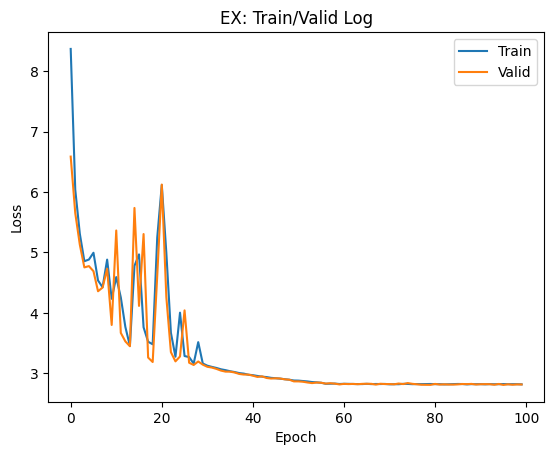

In [18]:
eval_utility.plot_training(**plot_training_params)

In [49]:
eval_instance_params = {
    'A': next(iter(valid_dataloader))[0],
    'model': model,
    'ind': 0,
    'size': Config.mat_size,
    'batch_size': Config.batch_size,
    'device': device,
    'file_path': 'ex.png'
}

Inner DET: 2.907607374675191e-35
Output min: 0.20854869484901428


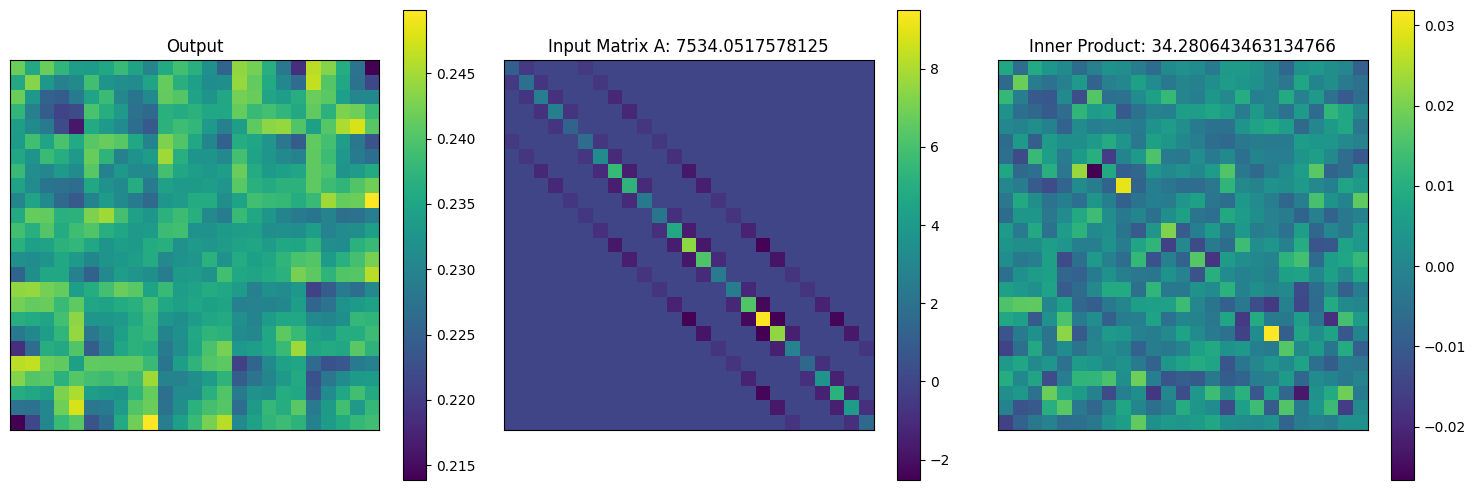

In [50]:
eval_utility.inspect_instance(**eval_instance_params)

# Model Save/Load

Our built in saving functions. They use the standard torch api.

In [21]:
model_utility.save_model(model, Config.file_path)

In [22]:
model_utility.load_model(model, Config.file_path)

/data/users/jupyter-dam724/RL/precondition-discovery-contextual-bandit/Model/utility.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(sta

# Training Logs Save/Load

Built in saving/loading functions for training statistics. We use the standard numpy api.

In [23]:
eval_utility.save_logs(train_log, valid_log, Config.log_path)

Logs saved to: /data/users/jupyter-dam724/RL/precondition-discovery-contextual-bandit/RUNS/logs.npz


In [24]:
train_log, valid_log = eval_utility.read_logs(Config.log_path)

Logs read from: /data/users/jupyter-dam724/RL/precondition-discovery-contextual-bandit/RUNS/logs.npz


# Traditional Preconditioners

An optional section that can be utilized to view the output of traditional preconditioning techniques.

In [25]:
import numpy as np

In [26]:
data = next(iter(valid_dataloader))[0].numpy()
ind = 0

In [27]:
trad_precond_params = {
    'batch_matrix': data, 
    'ind': ind, 
    'fill_factor': 1, 
    'max_levels': 10, 
    'strength': 'classical'
}

The preconditioners converge on the block diagonal but is there any other patterning. It also looks like these have a strong main diagonal but the learned representation from the model has a weak diagonal.

/data/users/jupyter-dam724/RL/precondition-discovery-contextual-bandit/Model/scipy.py:16: SparseEfficiencyWarning: spilu converted its input to CSC format
  ilu = spla.spilu(A, fill_factor)
/data/users/jupyter-dam724/.local/lib/python3.9/site-packages/pyamg/aggregation/aggregation.py:215: SparseEfficiencyWarning: Implicit conversion of A to CSR
  warn('Implicit conversion of A to CSR', SparseEfficiencyWarning)


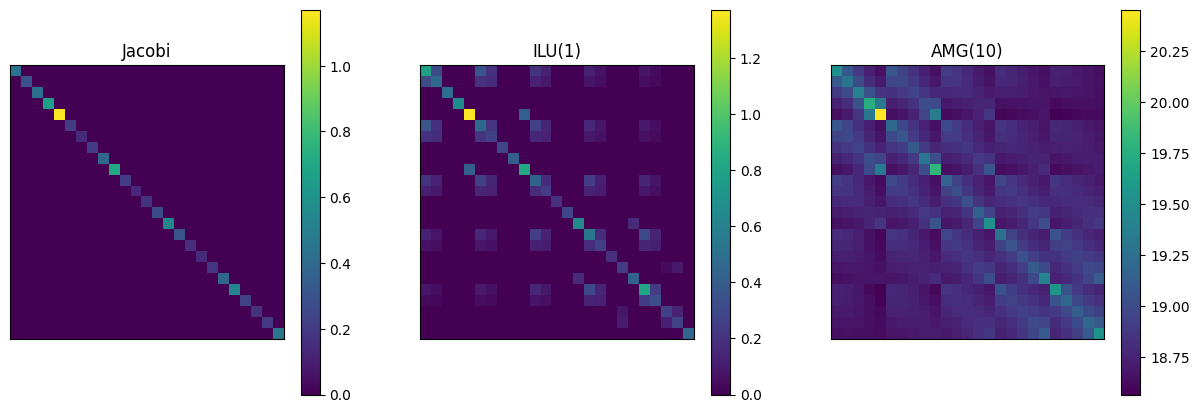

In [28]:
jac, ilu, amg = scipy.get_traditional_preconditioners(**trad_precond_params)

In [29]:
scipy.check_conditioning(data, np.eye(25), 0)
scipy.check_conditioning(data, jac, 0)
scipy.check_conditioning(data, ilu, 0)
scipy.check_conditioning(data, amg, 0)

Condition: 11745.455618057402
Condition: 11953.201434266472
Condition: 6646.172954686495
Condition: 25.000000033785227
